In [2]:
#---------Importing libraries---------#
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.datasets
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchinfo import summary

from tqdm.notebook import tqdm  # Progress bar
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
%matplotlib inline
import matplotlib_inline.backend_inline
from skimage import io
import splitfolders


matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export

## Data processing

In [3]:
#current folder
current_path = os.getcwd()
current_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector\\notebooks'

In [4]:
#go to parent folder to see the project path
project_path = os.path.abspath(os.path.join(current_path, os.pardir))
project_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector'

In [5]:
#set the data paths
DATA_DIR = os.path.join(project_path, 'data')
DATA_DIR_RAW = os.path.join(DATA_DIR, 'raw')
DATA_DIR_PROCESSED = os.path.join(DATA_DIR, 'processed')
DATA_DIR_RAW_IMG = os.path.join(DATA_DIR_RAW, 'images')
DATA_DIR_RAW_IMG_TRAIN = os.path.join(DATA_DIR_RAW_IMG, 'training')


In [6]:
path = '../data/raw/images/testing/flip'


os.path.join(project_path, 'data\\raw\\preprocessed\\images\\training')  

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector\\data\\raw\\preprocessed\\images\\training'

In [7]:
#splting the data into train and validation, run only once!
#splitfolders.ratio(DATA_DIR_RAW_IMG_TRAIN, output=DATA_DIR_PROCESSED , ratio=(0.8, 0.2)) # take the images of the training folder and split them into train and validation folders

# Data augmentation

## getting the mean and std of the normalized images

In [8]:
#getting the mean and std of the normalized images
import glob

images_path = os.path.join(DATA_DIR_RAW_IMG_TRAIN, 'flip')
images_files = [f for f in glob.glob(images_path + "**/*.jpg", recursive=True)]

#open the first image file
img = io.imread(images_files[0])
img.shape




(1920, 1080, 3)

In [9]:
def get_mean_std(images_path):
    """Get the mean and standard deviation of the images
    Args:
        images_path (str): path to the images folder

    Returns:
        mean (float): mean of the images
        std (float): standard deviation of the images"""
    
    images_files = [f for f in glob.glob(images_path + "**/*.jpg", recursive=True)]

    mean = np.zeros(3)
    stdTemp = np.zeros(3)
    std = np.zeros(3)
    nSamples = len(images_files)

    print('Calculating mean for each channel...')
    for i in tqdm(range(nSamples)):
        img = io.imread(images_files[i])
        img = img.astype(float)/255

        for j in range(3):
            mean[j] += img[:, :, j].mean()
        


    mean = mean/nSamples

    print('Calculating std for each channel...')
    for i in tqdm(range(nSamples)):
        img = io.imread(images_files[i])
        img = img.astype(float)/255

        for j in range(3):
            stdTemp[j] += ((img[:, :, j] - mean[j])**2).sum()/(img.shape[0]*img.shape[1])

    std = np.sqrt(stdTemp/(nSamples - 1))

    return mean, std




In [10]:
#calculating the mean and std of the images

# image_folder = os.path.join(DATA_DIR_RAW_IMG_TRAIN, 'flip')
# mean, std = get_mean_std(image_folder)
# print('mean: ', mean)
# print('std: ', std)

question: how to get the mean and std?

In [11]:
#creating transformation variables
mean = np.array([0.57647944, 0.52539918, 0.49818376])
std = np.array([0.21990674, 0.23702262, 0.24528695])

train_transform = T.Compose([
    T.Resize((224,224)), 
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
    
])

val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
    
])

test_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])



# Preparing data to train the model

In [12]:
#creating the datasets , with imagefolder to load the images even if they are in different folders.

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'train'),
                                                  transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'val'),
                                                    transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_RAW_IMG, 'testing'),
                                                    transform=test_transform)


In [13]:
#checking ou the classes and counts for each dataset

#training dataset
print('Train dataset classes: ', train_dataset.classes)
print('Train dataset classes labels: ', train_dataset.class_to_idx)
print('Train dataset classes counts: ', train_dataset.targets.count(0), train_dataset.targets.count(1))
print('Train dataset length: ', len(train_dataset))

print('\n----------------------------------\n')

#validation dataset
print('Validation dataset classes: ', val_dataset.classes)
print('Validation dataset classes labels: ', val_dataset.class_to_idx)
print('Validation dataset classes counts: ', val_dataset.targets.count(0), val_dataset.targets.count(1))
print('Validation dataset length: ', len(val_dataset))

print('\n----------------------------------\n')
#test dataset
print('Test dataset classes: ', test_dataset.classes)
print('Test dataset classes labels: ', test_dataset.class_to_idx)
print('Test dataset classes counts: ', test_dataset.targets.count(0), test_dataset.targets.count(1))
print('Test dataset length: ', len(test_dataset))

Train dataset classes:  ['flip', 'notflip']
Train dataset classes labels:  {'flip': 0, 'notflip': 1}
Train dataset classes counts:  929 984
Train dataset length:  1913

----------------------------------

Validation dataset classes:  ['flip', 'notflip']
Validation dataset classes labels:  {'flip': 0, 'notflip': 1}
Validation dataset classes counts:  233 246
Validation dataset length:  479

----------------------------------

Test dataset classes:  ['flip', 'notflip']
Test dataset classes labels:  {'flip': 0, 'notflip': 1}
Test dataset classes counts:  290 307
Test dataset length:  597


In [14]:
#creating our dataloader function

def get_data_loader(dataset, batch_size=16, shuffle=True, drop_last=True):
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              drop_last=drop_last)
    return data_loader

question: How to choose batch size?

In [15]:
#showing transformed images
def show_transformed_images(dataset):
    loader = get_data_loader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = make_grid(images, nrow=3) # nrow is the number of images displayed in a row
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0)) # permute to change the order of the channels from CxHxW to HxWxC
    plt.title('labels: {} \n where 0 is flipping and 1 is not fliping'.format(labels))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


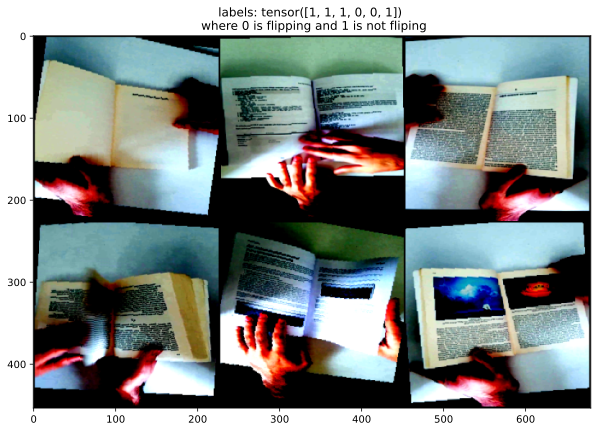

In [16]:
show_transformed_images(train_dataset)

In [17]:
#getting the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=16,
                                         shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,)

In [18]:
inputs, classes = next(iter(train_loader))

print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')
print(f'Labels of the first batch: {classes}')
#print the shape of the target
print('Target shape: ', classes.shape)

Batch size: 16
Number of color channels: 3
Image size: 224 x 224
Labels of the first batch: tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0])
Target shape:  torch.Size([16])


# Checking device and setting deterministic options

In [19]:
print("Using torch", torch.__version__)

Using torch 2.1.0


In [20]:
torch.manual_seed(42)  # Setting the seed

In [21]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [22]:
# Check device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [23]:
if torch.cuda.is_available(): # GPU operations have a separate seed we also want to set
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Creating a model

### ex of linear layer calculation

import torch
import torch.nn as nn

* Example input image dimensions (assuming grayscale images)
input_height = 128
input_width = 128
input_channels = 1  # Grayscale image

* Convolutional layer parameters
conv_out_channels = 16
conv_kernel_size = 3
conv_stride = 1
conv_padding = 1

* Max pooling parameters
pool_kernel_size = 2
pool_stride = 2

* Calculate output size after convolution

 conv_output_height = ((input_height - conv_kernel_size + 2 * conv_padding) / conv_stride) + 1

 conv_output_width = ((input_width - conv_kernel_size + 2 * conv_padding) / conv_stride) + 1

* Calculate output size after max pooling
pool_output_height = conv_output_height / pool_kernel_size
pool_output_width = conv_output_width / pool_kernel_size

* Calculate flattened size for nn.Linear
flattened_size = int(conv_out_channels * pool_output_height * pool_output_width)

* Define the fully connected (nn.Linear) layer
linear_input_size = flattened_size
linear_output_size = num_classes  # Number of output classes for classification

* Create the nn.Linear layer
linear_layer = nn.Linear(linear_input_size, linear_output_size)


In [24]:
#convolutional neural network
#image shape = 224x224x3
#classes = 2

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 3 input channels, 32 kernerls, 3x3 kernel, stride of 1. Stride is the step size of the kernel
            #nn.BatchNorm2d(32), # BatchNorm2d normalizes the output of the previous layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 2x2 kernel, stride of 2. MaxPool2d is a downsampling operation
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, 3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, 3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting

            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting

            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting




            nn.Flatten(), # Flatten the output of the previous layer to a vector
            #nn.linear input size: (Input Width - Kernel size + 2*Padding / Stride) + 1
            #input size = 224x224x3
            #after first conv2d layer = (224 - 3 + 2*1 / 1) + 1 => (224x224)x32
            #after first maxpool2d layer = 112x112x32
            #after second conv2d layer = 112x112x64
            #after second maxpool2d layer = 56x56x64
            #after third conv2d layer = 28x28x64
            #after third maxpool2d layer = 28x28x64
            #after fourth conv2d layer = 14x14x32
            #after fourth maxpool2d layer = 14x14x32
            #after fifth conv2d layer = 7x7x32
            #after fifth maxpool2d layer = 7x7x32


            
            nn.Linear(7*7*32, 1024), # input features, 1024 output features
            nn.ReLU(),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1), # Dropout layer to reduce overfitting
            nn.Linear(32,1) # 32 input features, 1 output features (0 or 1)


        
            
            
  
        )
        
    def forward(self, x):
        return torch.sigmoid(self.model(x)) # Sigmoid activation function for binary classification BCE LOSS
        







In [25]:
cnn_model = ConvNet().to(device)

import torchsummary
torchsummary.summary(cnn_model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 112, 112]        --
|    └─Dropout: 2-4                      [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-6                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 56, 56]          --
|    └─Dropout: 2-8                      [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─ReLU: 2-10                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 28, 28]         --
|    └─Dropout: 2-12                     [-1, 128, 28, 28]         --
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 112, 112]        --
|    └─Dropout: 2-4                      [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-6                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 56, 56]          --
|    └─Dropout: 2-8                      [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─ReLU: 2-10                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 28, 28]         --
|    └─Dropout: 2-12                     [-1, 128, 28, 28]         --
|    └

In [26]:
#optimizer
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
loss_fn = nn.BCELoss() # Binary cross entropy loss for binary classification

In [27]:
MODEL_DIR = os.path.join(project_path, 'models')

In [28]:
#creating a early stopping class

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0.001, path=os.path.join(MODEL_DIR, 'checkpoint.pt'), trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0.001
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [41]:
def train_model(model, criterion, optimizer, trainloader, valloader, epochs=5, patience=7, verbose=True, model_dir=MODEL_DIR):
    
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    
    #initialize the last best weitghts
    if os.path.exists(os.path.join(model_dir, 'checkpoint.pt')):
        model.load_state_dict(torch.load(os.path.join(model_dir, 'checkpoint.pt')))
        print('Loaded checkpoint with the best model.')
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    #using tqdm to show the progress bar

    for epoch in tqdm(range(epochs)):
        train_batch_loss = 0
        train_batch_acc = 0
        val_batch_loss = 0
        val_batch_accuracy = 0
        

        # Training mode
        model.train()
        for X, y in trainloader:
            ## move data to device
            X = X.to(device)
            y = y.to(device)
            ## reset the gradient
            optimizer.zero_grad()
            ## forward pass
            y_hat = model(X).flatten()
            ## calculate the loss
            loss = criterion(y_hat, y.type(torch.float32))
            ## backpropagation
            loss.backward()
            ## update the weights
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (torch.round(y_hat) == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))
        
        
        # Validation
        model.eval()
        for data, target in tqdm(valloader):
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).flatten()
            # calculate the loss
            loss = criterion(output, target.type(torch.float32))
            val_batch_loss += loss.item()
            val_batch_accuracy += (torch.round(output) == target).type(torch.float32).mean().item()
            

        ## record validation loss
        val_loss.append(val_batch_loss / len(valloader))
        val_accuracy.append(val_batch_accuracy / len(valloader))
        

        ## Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Validation Loss: {val_loss[-1]:.3f}",
                  f"Validation Accuracy: {val_accuracy[-1]:.2f}")
            
        
        ## early_stopping needs the validation loss to check if it has decresed, 
        ## and if it has, it will make a checkpoint of the current model
        val_loss_arr = np.average(val_loss)
        early_stopping(val_loss_arr, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

       
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "val_loss": val_loss,
               "val_accuracy": val_accuracy}
   
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(os.path.join(  model_dir  ,'checkpoint.pt')))

    return results, train_loss, train_accuracy, val_loss, val_accuracy

In [42]:
#training the model
results, train_loss, train_accuracy, val_loss, val_accuracy = train_model(cnn_model, criterion=loss_fn, optimizer=optimizer, trainloader=train_loader, valloader=val_loader, epochs=2, patience=8, verbose=True)

Loaded checkpoint with the best model.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.693 Train Accuracy: 0.51 Validation Loss: 0.693 Validation Accuracy: 0.51
Validation loss decreased (inf --> 0.692779).  Saving model ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.693 Train Accuracy: 0.51 Validation Loss: 0.693 Validation Accuracy: 0.51
EarlyStopping counter: 1 out of 8


In [49]:
#saving results
RESULTS_DIR = os.path.join(MODEL_DIR, 'results')
def save_model_results(train_loss, train_accuracy, val_loss, val_accuracy, model_name:str, results_dir = RESULTS_DIR ):
    #creating a folder inside results dir. The folder name is the model name
    #first check if the folder exists
    if not os.path.exists(os.path.join(results_dir, model_name)):
        os.makedirs(os.path.join(results_dir, model_name))
    #save the results
        #save the training loss and accuracy
    np.save(os.path.join(results_dir, model_name, 'train_loss.npy'), np.array(train_loss))#
    np.save(os.path.join(results_dir, model_name, 'train_loss.npy'), np.array(train_loss))
    np.save(os.path.join(results_dir, model_name, 'train_accuracy.npy'), np.array(train_accuracy))
        # save the validation loss and accuracy
    np.save(os.path.join(results_dir, model_name, 'val_loss.npy'), np.array(val_loss))
    np.save(os.path.join(results_dir, model_name, 'val_accuracy.npy'), np.array(val_accuracy))
    print('Results saved!')

In [50]:
#saving results of cnn_model
save_model_results(train_loss, train_accuracy, val_loss, val_accuracy, 'cnn_model')

Results saved!


In [36]:
#getting the model with the best state
cnn_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'checkpoint.pt')))

<All keys matched successfully>

In [37]:
#save the model
torch.save(cnn_model.state_dict(), os.path.join(MODEL_DIR, 'cnn_model.pt'))

In [38]:
#load the model
cnn_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'cnn_model.pt')))

<All keys matched successfully>

In [43]:
#testing the model

def test_model(model, criterion, testloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in testloader:
      X = X.to(device)
      y = y.to(device)
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y).sum()
    
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))

In [39]:
test_model(cnn_model, loss_fn, test_loader)


Test set: Avg. loss: 0.6929, Accuracy: 307/597 (51%)



In [51]:
def plot_results(model_name:str, results_dir = RESULTS_DIR):


    ## load the training loss and accuracy
    train_loss = np.load(os.path.join(results_dir, model_name, 'train_loss.npy'))
    train_accuracy = np.load(os.path.join(results_dir, model_name, 'train_accuracy.npy'))
    ## load the validation loss and accuracy
    val_loss = np.load( os.path.join(results_dir, model_name, 'val_loss.npy'))
    val_accuracy = np.load(os.path.join(results_dir, model_name, 'val_accuracy.npy'))

    ## plot the training loss and accuracy
    plt.figure(figsize=(16,8))
    plt.plot(train_loss,color="r",marker="o", label="Training Loss")
    plt.plot(train_accuracy, color='b', marker='x')

    ## plot the validation loss and accuracy
    plt.plot(val_loss,color="g",marker="o", label="Validation Loss")
    plt.plot(val_accuracy, color='y', marker='x', label="Validation Accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Loss and Accuracy")
    plt.legend(["Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"])
    plt.show()

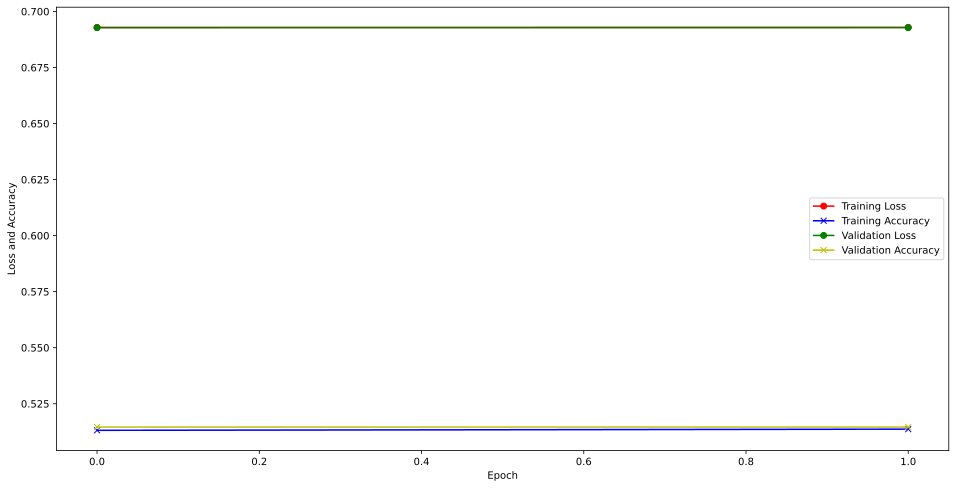

In [52]:
#ploting the results for cnn_model
plot_results('cnn_model')

In [53]:
#training the data with Mobile Net
#loading the model
mobilenet_model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
mobilenet_model.eval()

#freezing the parameters for the n-2 layers
for param in mobilenet_model.parameters():
    param.requires_grad = False

#changing the last 2 layers
mobilenet_model.classifier[1] = nn.Linear(1280, 64)
mobilenet_model.classifier[4] = nn.Linear(64, 1)

mobilenet_model = mobilenet_model.to(device)

#optimizer
optimizer = torch.optim.SGD(mobilenet_model.parameters(), lr=0.001, momentum=0.9)

#model summary

torchsummary.summary(mobilenet_model, (3, 224, 224))



Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to C:\Users\Usuario/.cache\torch\hub\v0.6.0.zip
c:\Users\Usuario\anaconda3\envs\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\anaconda3\envs\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Usuario/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 27.9MB/s]


IndexError: index 4 is out of range